In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import ipywidgets as widgets
from IPython.display import display

C:\Users\Naina\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Naina\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\Naina\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load Dataset

In [7]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Set the path to your image dataset directory
image_dataset_path = "archive/img_align_celeba/img_align_celeba/"

# Function to load and preprocess images
def load_and_preprocess_images(image_path, image_files, target_size=(48, 48)):
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_dataset_path, image_file)
        img = load_img(image_path, target_size=target_size, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1]
        images.append(img_array)
    return np.array(images)

# Get a list of image file names in the dataset directory
image_files = [f for f in os.listdir(image_dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Load and preprocess images
input_images = load_and_preprocess_images(image_dataset_path, image_files)

# Display the shape of the input image data
print("Shape of the input image data:", input_images.shape)


Shape of the input image data: (22587, 48, 48, 1)


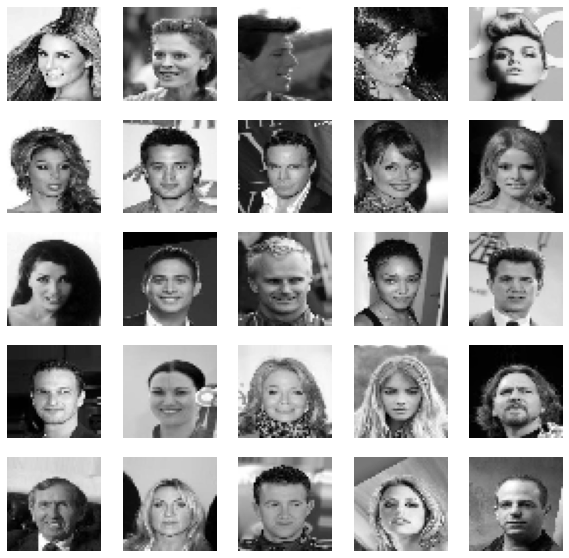

In [11]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(input_images[i],cmap = 'gray')
    plt.axis('off')

Defining Batch Size and Shuffling

In [13]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(input_images).batch(batch_size).shuffle(132)  

Sampling

In [14]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs;
        batch = tf.shape(z_mean)[0]
        dimension = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch, dimension))
        return z_mean + tf.exp(z_log_var * 0.5) * epsilon

Encoder

In [15]:
latent_dim = 3
encoder_inputs = layers.Input(shape = (48,48,1))
x = layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu', padding = 'same')(encoder_inputs)
x = layers.Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x)
x = layers.Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu')(x)
x = layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x)
x = layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu')(x)
x = layers.Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x)

x = layers.Flatten()(x)
mean = layers.Dense(latent_dim)(x)
log_var = layers.Dense(latent_dim)(x)
z = Sampling()([mean, log_var])

encoder = tf.keras.Model(encoder_inputs, [mean,log_var,z])

encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 47, 47, 64)   8256        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 23, 23, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

Decoder

In [16]:
decoder_input = layers.Input(shape = (latent_dim,))

x = layers.Dense(6*6*32, activation = 'relu')(decoder_input)

x = layers.Reshape((6,6,32))(x)
x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.Conv2D(filters = 128, kernel_size = (2,2), padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters = 128, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.Conv2D(filters = 256, kernel_size = (2,2), padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(filters = 256, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.Conv2D(filters =128, kernel_size = (2,2), padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters = 1, kernel_size = (2,2), padding = 'same')(x)

decoder = tf.keras.Model(decoder_input, x)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 1152)              4608      
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 64)          8256      
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 64)          16448     
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 64)         256       
 ormalization)                                                   
                                                           

VAE model

In [17]:
inp = encoder.input
out = encoder.output
decoder_output = decoder(out[2])
vae = tf.keras.Model(inp, decoder_output)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 47, 47, 64)   8256        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 23, 23, 64)   0           ['conv2d_1[0][0]']               
                                                                                            

Loss Function

In [18]:
def kl_loss(z_log_var,z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return kl_loss * 0.012


loss = tf.keras.losses.BinaryCrossentropy()
def reconstruction_loss(data,reconstructed):
    return loss(data,reconstructed)
optimizer = tf.keras.optimizers.Adam()

Train

In [24]:
def train_steps(data):
    with tf.GradientTape() as vae_tape:
        z_mean,z_log_var,z = encoder(data)
        reconstructed_image = decoder(z)
        kl_ = kl_loss(z_log_var,z_mean)
        reconstruction_ = reconstruction_loss(data, reconstructed_image)
        total_loss = kl_ + reconstruction_

    gradient2 = vae_tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradient2, vae.trainable_variables))

noise = tf.keras.backend.random_normal(shape = (9,latent_dim))
def visualize(epoch):
        prediction = decoder(noise)
        plt.figure(figsize = (5,5))
        for i in range(9):
            if(i == 2):
                plt.title("Epoch: {}".format(epoch))
            plt.subplot(3,3,i+1)
            plt.imshow(prediction[i],cmap = 'gray')
            plt.axis('off')
            
import time
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for data in dataset:
            train_steps(data)
        print("Epoch: {} Time: {}".format(epoch+1,np.round(time.time()-start),3))
        if epoch % 3 == 0:
            visualize(epoch+1)

Epoch: 1 Time: 571.0
Epoch: 2 Time: 525.0
Epoch: 3 Time: 602.0
Epoch: 4 Time: 520.0
Epoch: 5 Time: 500.0
Epoch: 6 Time: 517.0
Epoch: 7 Time: 546.0
Epoch: 8 Time: 599.0
Epoch: 9 Time: 614.0
Epoch: 10 Time: 596.0


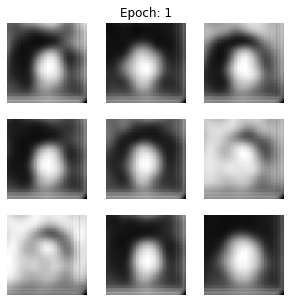

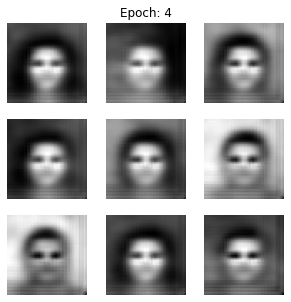

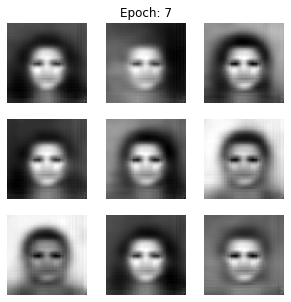

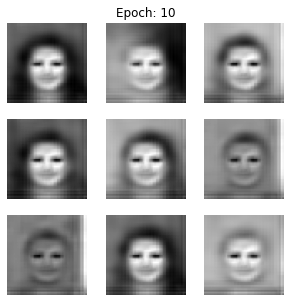

In [25]:
num_epochs = 10

# Start training
train(dataset, num_epochs)

Epoch: 1 Time: 620.0
Epoch: 2 Time: 630.0
Epoch: 3 Time: 784.0
Epoch: 4 Time: 827.0
Epoch: 5 Time: 834.0


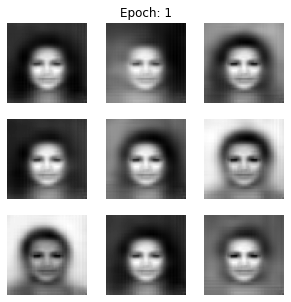

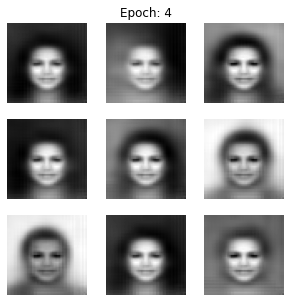

In [26]:
num_epochs = 5

train(dataset, num_epochs)

Epoch: 1 Time: 917.0
Epoch: 2 Time: 914.0


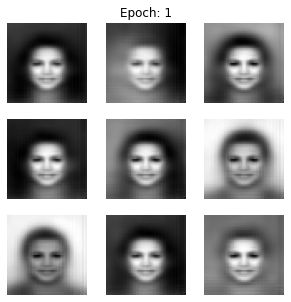

In [27]:
num_epochs = 2

train(dataset, num_epochs)

In [28]:
num_epochs = 4

Epoch: 1 Time: 2817.0
Epoch: 2 Time: 2810.0
Epoch: 3 Time: 1871.0
Epoch: 4 Time: 979.0


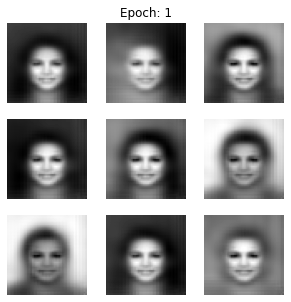

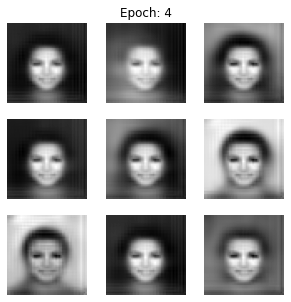

In [30]:
train(dataset , num_epochs)

In [44]:
vae.save('/content/saved_model/my_vae_model.h5')

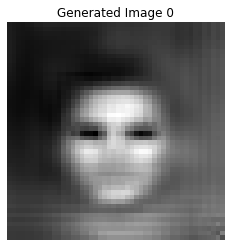

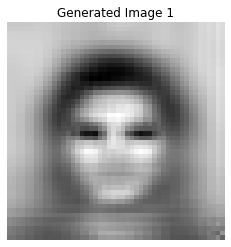

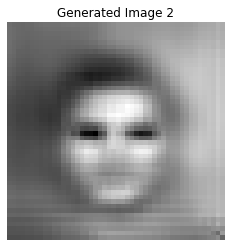

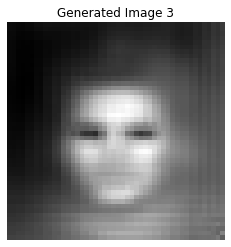

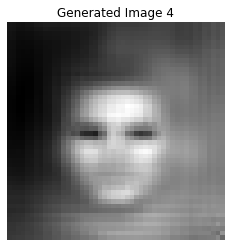

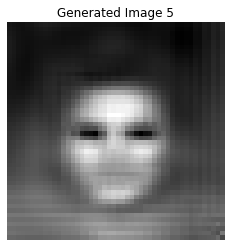

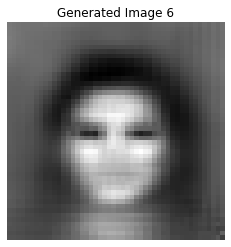

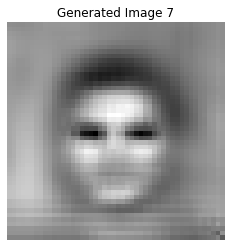

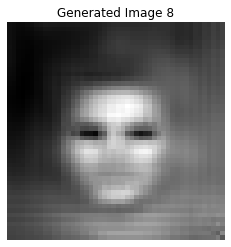

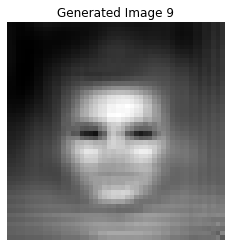

In [43]:
def generate_and_save_images(model, num_images, save_folder):
    noise = tf.keras.backend.random_normal(shape=(num_images, 48, 48, 1))
    predictions = model(noise)

    # Rescale pixel values to the range [0, 1]
    predictions = np.clip(predictions, 0.0, 1.0)

    # Create a folder for generated images
    os.makedirs(save_folder, exist_ok=True)

    for i, img in enumerate(predictions):
        img_path = os.path.join(save_folder, f'generated_image_{i}.png')
        plt.imsave(img_path, img.squeeze(), cmap='gray')

        # Display the generated image
        plt.figure()
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Generated Image {i}')
        plt.axis('off')
        plt.show()

generate_and_save_images(vae, 10, 'predicted_images')
